In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib
import matplotlib.pyplot as plt
import tempfile
import argparse
import math

import seaborn as sns
import pandas as  pd

# Scaler for data
from sklearn.preprocessing import StandardScaler


In [2]:
# Find what device to work with
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

## Generate Boston Housing Dataset .pt (only run once)

In [3]:
data = np.loadtxt('Experiments/Boston/Data/boston_housing.txt')
X = data[:, range(data.shape[ 1 ] - 1) ]
y = data[:, data.shape[ 1 ] - 1 ]

permutation = np.random.choice(range(X.shape[0]), X.shape[0], replace = False)
size_train = np.round(X.shape[0]*0.9)
index_train = permutation[0:int(size_train)]
index_test = permutation[int(size_train) : ]

X_train = X[ index_train, : ]
y_train = y[ index_train ]
X_test = X[ index_test, : ]
y_test = y[ index_test ]

X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)

X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)


torch.save(X_train, 'Experiments/Boston/Data/boston_train_X.pt')
torch.save(y_train, 'Experiments/Boston/Data/boston_train_y.pt')

torch.save(X_test, 'Experiments/Boston/Data/boston_test_X.pt')
torch.save(y_test, 'Experiments/Boston/Data/boston_test_y.pt')

In [4]:
from sklearn.datasets import load_boston
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


# Data #

In [5]:
x_train = torch.load('Experiments/Boston/Data/boston_train_X.pt')
scaler_x = StandardScaler()
x_train=torch.as_tensor(scaler_x.fit_transform(x_train), device=device).float()

y_train = torch.load('Experiments/Boston/Data/boston_train_y.pt').unsqueeze(-1)
scaler_y = StandardScaler()
y_train=torch.as_tensor(scaler_y.fit_transform(y_train), device=device).float()



x_test = torch.load('Experiments/Boston/Data/boston_test_X.pt')
x_test=torch.as_tensor(scaler_x.transform(x_test), device=device).float()

y_test = torch.load('Experiments/Boston/Data/boston_test_y.pt').to(device).float()


In [6]:
torch.std_mean(y_train)

(tensor(1.0011, device='cuda:1'), tensor(-8.3903e-09, device='cuda:1'))

# Predictive Net #

In [7]:
input_dim=13
nblayers = 1
activation_pn=nn.ReLU()
layerwidth = 50
param_count = (input_dim+1)*layerwidth+(nblayers-1)*(layerwidth**2+layerwidth)+layerwidth+1
param_count

751

In [8]:
def mlp(x,theta,input_dim=input_dim,layerwidth=layerwidth,nb_layers=nblayers,activation=activation_pn):
    """
    Feedforward neural network used as the observation model for the likelihood
    

    Parameters:
        x (Tensor): Input of the network of size NbExemples X NbDimensions   
        theta (Tensor):  M set of parameters of the network NbModels X NbParam
        input_dim (Int): dimensions of NN's inputs (=NbDimensions)
        layerwidth (Int): Number of hidden units per layer 
        nb_layers (Int): Number of layers
        activation (Module/Function): activation function of the neural network

    Returns:
        Predictions (Tensor) with dimensions NbModels X NbExemples X NbDimensions


    Example:

    input_dim=11
    nblayers = 2
    activation=nn.Tanh()
    layerwidth = 20
    param_count = (input_dim+1)*layerwidth+(nblayers-1)*(layerwidth**2+layerwidth)+layerwidth+1

    x=torch.rand(3,input_dim)
    theta=torch.rand(5,param_count)
    mlp(x,theta,input_dim=input_dim,layerwidth=layerwidth,nb_layers=nblayers,activation=activation)

    """

    nb_theta=theta.shape[0]
    nb_x=x.shape[0]
    split_sizes=[input_dim*layerwidth]+[layerwidth]+[layerwidth**2,layerwidth]*(nb_layers-1)+[layerwidth,1]
    theta=theta.split(split_sizes,dim=1)
    input_x=x.view(nb_x,input_dim,1)
    m=torch.matmul(theta[0].view(nb_theta,1,layerwidth,input_dim),input_x)
    m=m.add(theta[1].reshape(nb_theta,1,layerwidth,1))
    m=activation(m)
    for i in range(nb_layers-1):
        m=torch.matmul(theta[2*i+2].view(-1,1,layerwidth,layerwidth),m)
        m=m.add(theta[2*i+3].reshape(-1,1,layerwidth,1))
        m=activation(m)
    m=torch.matmul(theta[2*(nb_layers-1)+2].view(nb_theta,1,1,layerwidth),m)
    m=m.add(theta[2*(nb_layers-1)+3].reshape(nb_theta,1,1,1))
    return m.squeeze(-1)

# Posterior density #

In [9]:
sigma_noise = torch.tensor(1.)

In [10]:
def _log_norm(x, mu, std):
    """
    Evaluation of 1D normal distribution on tensors

    Parameters:
        x (Tensor): Data tensor of size B X S 
        mu (Tensor): Mean tensor of size S 
        std (Float): Positive scalar (standard deviation)

    Returns:
        logproba (Tensor): Same size as x with logproba(b,i)=log p(x(b,i),mu(i),std)
    """
    B=x.shape[0]
    S=x.shape[1]
    var=torch.as_tensor(std**2,device=device)
    d=(x.view(B,S,1)-mu.view(1,S,1))**2
    c=2*math.pi*var
    return -0.5 * (1/(var))*d -0.5 * c.log()

In [11]:
S = torch.ones(param_count).to(device)
mu = torch.zeros(param_count).to(device)
dim=param_count
def logprior(x,m=mu, s=S,dim=dim):
    n_x=x.shape[0]
    H=S.view(dim,1,1).inverse().view(1,1,dim)
    d=((x-mu.view(1,dim))**2).view(n_x,dim)
    const=0.5*S.log().sum()+0.5*dim*torch.tensor(2*math.pi).log()
    return -0.5*(H*d).sum(2).squeeze()-const
#test!
#prior=torch.distributions.multivariate_normal.MultivariateNormal(mu,covariance_matrix=torch.diagflat(S))
#x=torch.rand(10,param_count).to(device)
#torch.allclose(logprior(x),prior.log_prob(x))


In [12]:
def loglikelihood(theta, x, y, sigma_noise):
        y_pred = mlp(x, theta)
        L=_log_norm(y_pred,y,sigma_noise)
        return torch.sum(L, dim=1).squeeze()

In [13]:
def logposterior(theta, x, y, sigma_noise):
        return logprior(theta)+loglikelihood(theta, x, y, sigma_noise)

In [14]:
logtarget = lambda theta : logposterior(theta, x_train, y_train, sigma_noise )

# Hypernet #

In [15]:
ensemble_size=1
lat_dim=5
HN_layerwidth=50
init_w=.2
init_b=.001
activation=nn.ReLU()
output_dim=param_count
#x_train, y_train = exp.get_training_data(device)

In [16]:
#x_train = x_train[:,:1].float()

In [17]:
#y_train = y_train.float()

In [18]:
class HNet(nn.Module):
            def __init__(self, lat_dim, nb_neur, output_dim,  activation=nn.ReLU(), init_w=.1, init_b=.1):
                super(HNet, self).__init__()
                self.lat_dim = lat_dim
                self.output_dim=output_dim
                self.hnet=nn.Sequential(
                        nn.Linear(lat_dim,nb_neur),
                        activation,
                        nn.Linear(nb_neur,output_dim)
                        ).to(device)
                
                torch.nn.init.normal_(self.hnet[2].weight,mean=0., std=init_w)
                torch.nn.init.normal_(self.hnet[2].bias,mean=0., std=init_b)
    
            def forward(self, n=1):
                epsilon = torch.randn(size=(n,self.lat_dim)).to(device)
                return self.hnet(epsilon)           

class HyNetEns(nn.Module):
    def __init__(self,nb_comp,lat_dim,layer_width, output_dim, activation, init_w,init_b):
        super(HyNetEns, self).__init__()
        self.nb_comp=nb_comp
        self.output_dim=output_dim
        self.components= nn.ModuleList([HNet(lat_dim,layer_width,output_dim,activation,init_w,init_b) for i in range(nb_comp)]).to(device)   
    def sample(self, n=1):
        return torch.stack([self.components[c](n) for c in range(self.nb_comp)])

    
    def forward(self, n=1):
        d = torch.distributions.multinomial.Multinomial(n, torch.ones(self.nb_comp))
        m = d.sample()
        return torch.cat([self.components[c](int(m[c])) for c in range(len(self.components))])

In [19]:
Hyper_Nets=HyNetEns(ensemble_size,lat_dim,HN_layerwidth, output_dim,activation,init_w,init_b).to(device)


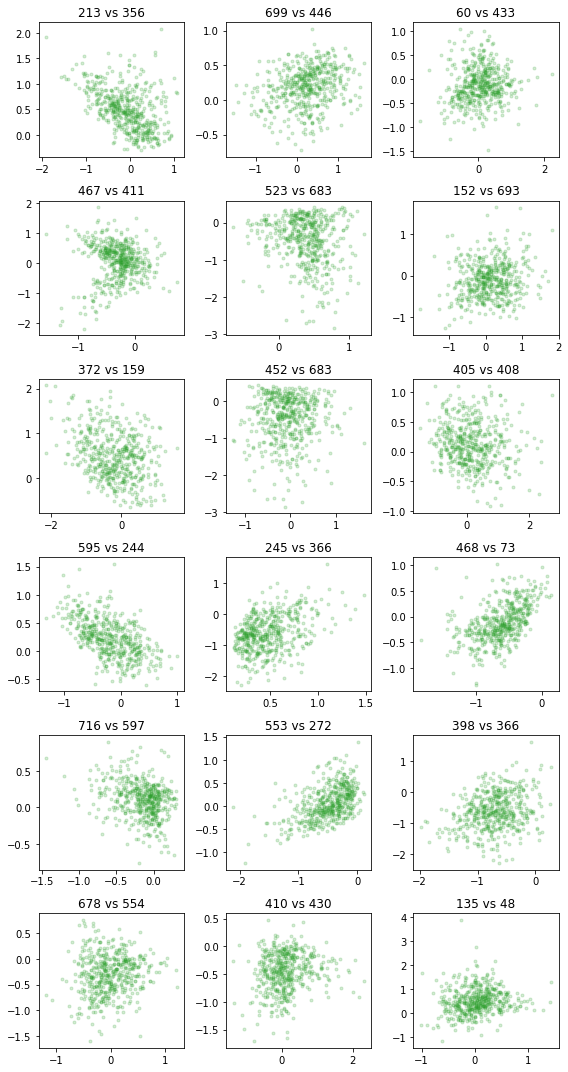

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

theta =Hyper_Nets.sample(500).cpu().detach().numpy()

fig, axs = plt.subplots(6, 3,figsize=(8,15))
for k in range(6):
    for l in range(3):
        i=np.random.choice(a=np.arange(param_count), size=2,replace=False)
        axs[k, l].set(title=str(i[0])+' vs '+str(i[1]))
        for c in range(Hyper_Nets.nb_comp):
            axs[k, l].scatter(theta[c,:,i[0]],theta[c,:,i[1]],marker='.',alpha=0.2,color='C'+str(c+2))

fig.tight_layout()

# Entropy estimation #

In [21]:
def KDE(x,y,prec):
    """
    KDE    
    
    Parameters:
        x (Tensor): Inputs, NbExemples X NbDimensions   
        y (Tensor):  Batched samples, NbBatch x NbSamples X NbDimensions
        prec (Float): scalar factor for bandwidth scaling
    

    Returns:
        (Tensor) KDE estimate for x based on batched diagonal "Silverman's rule of thumb", NbExemples X 1
        See Wand and Jones p.111 "Kernel Smoothing" 1995.  
    
    """
    
    dim=x.shape[-1]
    n_ed=x.shape[0]
    n_comp=y.shape[0]
    n_kde=y.shape[1]
    c_=(n_kde*(dim+2))/4
    c=torch.as_tensor(c_).pow(2/(dim+4)).to(device)  
    H=prec*(y.var(1)/c).clamp(torch.finfo().eps,float('inf'))

    d=((y.view(n_comp,n_kde,1,dim)-x.view(1,1,n_ed,dim))**2)
    H_=H.view(n_comp,dim,1,1).inverse().view(n_comp,1,1,dim)
    const=0.5*H.log().sum(1)+0.5*dim*torch.tensor(2*math.pi).log()
    const=const.view(n_comp,1,1)
    ln=-0.5*(H_*d).sum(3)-const
    N=torch.as_tensor(float(n_comp*n_kde),device=device)
    return (ln.logsumexp(0).logsumexp(0)-torch.log(N)).unsqueeze(-1)


def NNE(theta,k=1):
    """
    Parameters:
        theta (Tensor): Samples, NbExemples X NbDimensions   
        k (Int): ordinal number

    Returns:
        (Float) k-Nearest Neighbour Estimation of the entropy of theta  
    
    """
    nb_samples=theta.shape[0]
    dim=theta.shape[1]
    D=torch.cdist(theta,theta)
    a = torch.topk(D, k=k+1, dim=0, largest=False, sorted=True)[0][k].clamp(torch.finfo().eps,float('inf')).to(device)
    d=torch.as_tensor(float(dim),device=device)
    K=torch.as_tensor(float(k),device=device)
    N=torch.as_tensor(float(nb_samples),device=device)
    pi=torch.as_tensor(math.pi,device=device)
    lcd = d/2.*pi.log() - torch.lgamma(1. + d/2.0)
    return torch.digamma(N) - torch.digamma(K) + lcd + d/nb_samples*torch.sum(torch.log(a))

In [22]:
"""
Example of density estimation on Multivariate Normal

dim=100
p=torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(dim), torch.diagflat(2.*torch.ones(dim)))
print(p.entropy())
print(-KDE(p.sample((1,1000)).squeeze(0), p.sample((1,1000)),1.).mean())
print(NNE(p.sample((1,1000)).squeeze(0)))
"""

'\nExample of density estimation on Multivariate Normal\n\ndim=100\np=torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(dim), torch.diagflat(2.*torch.ones(dim)))\nprint(p.entropy())\nprint(-KDE(p.sample((1,1000)).squeeze(0), p.sample((1,1000)),1.).mean())\nprint(NNE(p.sample((1,1000)).squeeze(0)))\n'

# Metrics #

In [23]:
#NLPD from Quinonero-Candela and al.
# the average negative log predictive density (NLPD) of the true targets

def NLPD(theta, x, y, sigma_noise,inv_transform):
    y_pred =torch.as_tensor(inv_transform(mlp(x, theta).detach().cpu()),device=device)
    L = _log_norm(y_pred, y, sigma_noise)
    n_x = torch.as_tensor(float(x.shape[0]), device=device)
    n_theta = torch.as_tensor(float(theta.shape[0]), device=device)
    log_posterior_predictive = torch.logsumexp(L, 0) - torch.log(n_theta)
    return torch.mean(-log_posterior_predictive)

In [24]:
NLPD(Hyper_Nets(1000),x_test,y_test,sigma_noise, scaler_y.inverse_transform)


tensor(4.5658, device='cuda:1')

In [25]:
NLPD(Hyper_Nets(1000),x_test,y_test,sigma_noise,scaler_y.inverse_transform)

tensor(4.5609, device='cuda:1')

In [26]:
def RMSE(theta,x,y,inv_transform):
    n_samples=x.shape[0]
    y_pred =torch.as_tensor(inv_transform(mlp(x, theta).detach().cpu()),device=device).mean(0)
    mse=(y_pred-y.view(n_samples,1))**2
    return mse.mean().sqrt()

In [27]:
RMSE(Hyper_Nets(1000),x_test,y_test,scaler_y.inverse_transform)

tensor(25.3542, device='cuda:1')

In [28]:
RMSE(Hyper_Nets(1000),x_test,y_test,scaler_y.inverse_transform)

tensor(26.2897, device='cuda:1')

# Training #

In [29]:
KDE_prec=1.
n_samples_KDE=1000
n_samples_NNE=1000
n_samples_ED=50
n_samples_LP=100
max_iter=10000000000
learning_rate=0.03
min_lr=0.0000005
patience=500
lr_decay=0.8

In [30]:
-KDE(Hyper_Nets(n_samples_ED),Hyper_Nets.sample(n_samples_KDE),KDE_prec).mean()

tensor(117.5292, device='cuda:1', grad_fn=<NegBackward>)

In [31]:
NNE(Hyper_Nets(n_samples_NNE),1)

tensor(-363.4355, device='cuda:1', grad_fn=<AddBackward0>)

In [33]:

optimizer = torch.optim.Adam(Hyper_Nets.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)#optimizer, patience=patience, factor=lr_decay)


In [34]:
from livelossplot import PlotLosses

%matplotlib inline

liveloss = PlotLosses()

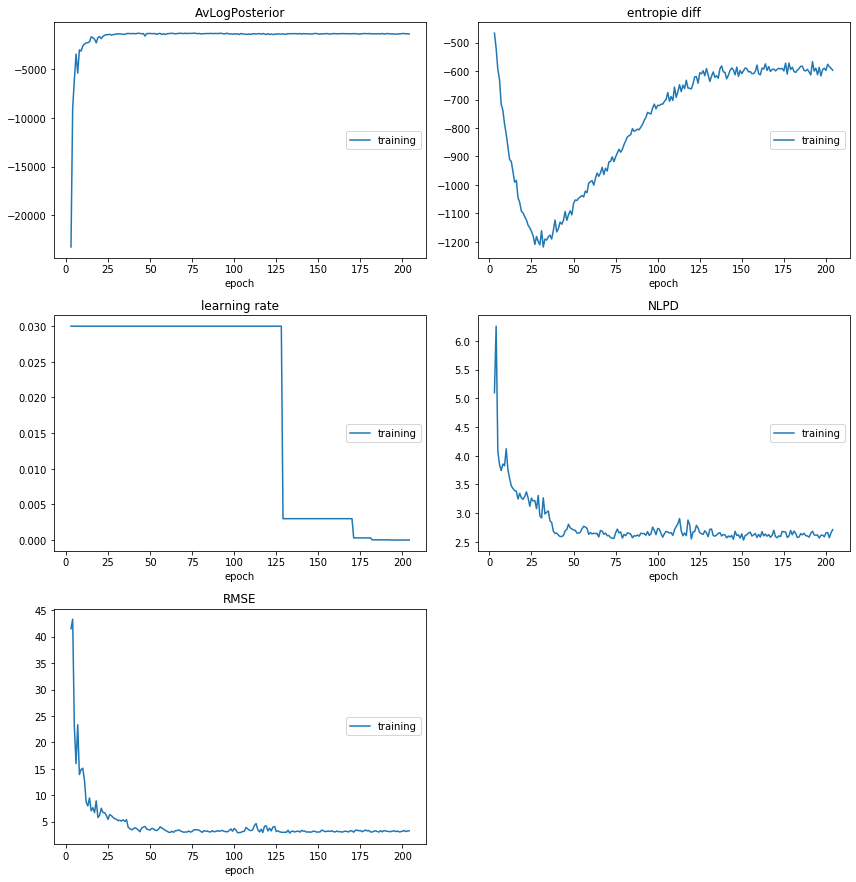

AvLogPosterior:
training   (min: -105430.320, max: -1275.278, cur: -1360.107)

entropie diff:
training   (min: -1217.922, max: -365.078, cur: -597.357)

learning rate:
training   (min:    0.000, max:    0.030, cur:    0.000)

NLPD:
training   (min:    2.530, max:  508.447, cur:    2.712)

RMSE:
training   (min:    2.826, max:  170.136, cur:    3.261)


In [35]:
%matplotlib inline


        
for t in range(max_iter):
    optimizer.zero_grad()
    logs = {}


#KDE:    
#    ED=-KDE(Hyper_Nets(n_samples_ED),Hyper_Nets.sample(n_samples_KDE),KDE_prec).mean()
#Nearest Neighbour Entropy estimation
    ED=NNE(Hyper_Nets(n_samples_NNE))
    LP=logtarget(Hyper_Nets(n_samples_LP)).mean()
    L =-ED-LP
#    L=-logtarget(theta).squeeze()
    L.backward()

    #training_loss.append(L.detach().clone().cpu().numpy())

    lr = optimizer.param_groups[0]['lr']

    if t % 1 == 0:
        logs['AvLogPosterior'] = LP.detach().clone().cpu().numpy()
        logs['entropie diff'] = ED.detach().clone().cpu().numpy()
        logs['learning rate'] = lr
    if t % 1 == 0:
        logs['NLPD'] = NLPD(Hyper_Nets(100).detach(),x_test,y_test,sigma_noise,scaler_y.inverse_transform).detach().clone().cpu().numpy()
        logs['RMSE'] = RMSE(Hyper_Nets(100).detach(),x_test,y_test,scaler_y.inverse_transform).detach().clone().cpu().numpy()
    liveloss.update(logs)
        
        
    scheduler.step(L.detach().clone().cpu().numpy())

    optimizer.step()
    
    if t % 1 == 0:
        
        liveloss.draw()

        


    if lr < min_lr:
        break



In [35]:
t

101

In [50]:
NLPD(Hyper_Nets(1000),torch.as_tensor(scaler_x.transform(X),device=device).float(),torch.as_tensor(y,device=device).unsqueeze(-1).float(),sigma_noise, scaler_y.inverse_transform)


tensor(2.6497, device='cuda:1')

In [56]:
NLPD(Hyper_Nets(1000),x_train,y_train,sigma_noise, lambda x:x)


tensor(1.1051, device='cuda:1')